Classification Report Summary:
               Genre  Precision (0)  Recall (0)  F1-Score (0)  Precision (1)  \
0           acoustic       0.618351    0.576454      0.596668       0.605560   
1          punk-rock       0.595491    0.514971      0.552312       0.575003   
2  progressive-house       0.715306    0.666460      0.690020       0.689535   
3          power-pop       0.655677    0.648441      0.652039       0.654342   
4                pop       0.627449    0.597876      0.612306       0.618177   
5           pop-film       0.819545    0.695515      0.752453       0.736917   
6              piano       0.695015    0.770608      0.730862       0.744345   
7              party       0.776886    0.729925      0.752673       0.746761   
8             pagode       0.790106    0.544411      0.644641       0.654071   
9              opera       0.577668    0.733357      0.646268       0.637971   

   Recall (1)  F1-Score (1)  Accuracy  Macro Precision  Macro Recall  \
0    0.646344   

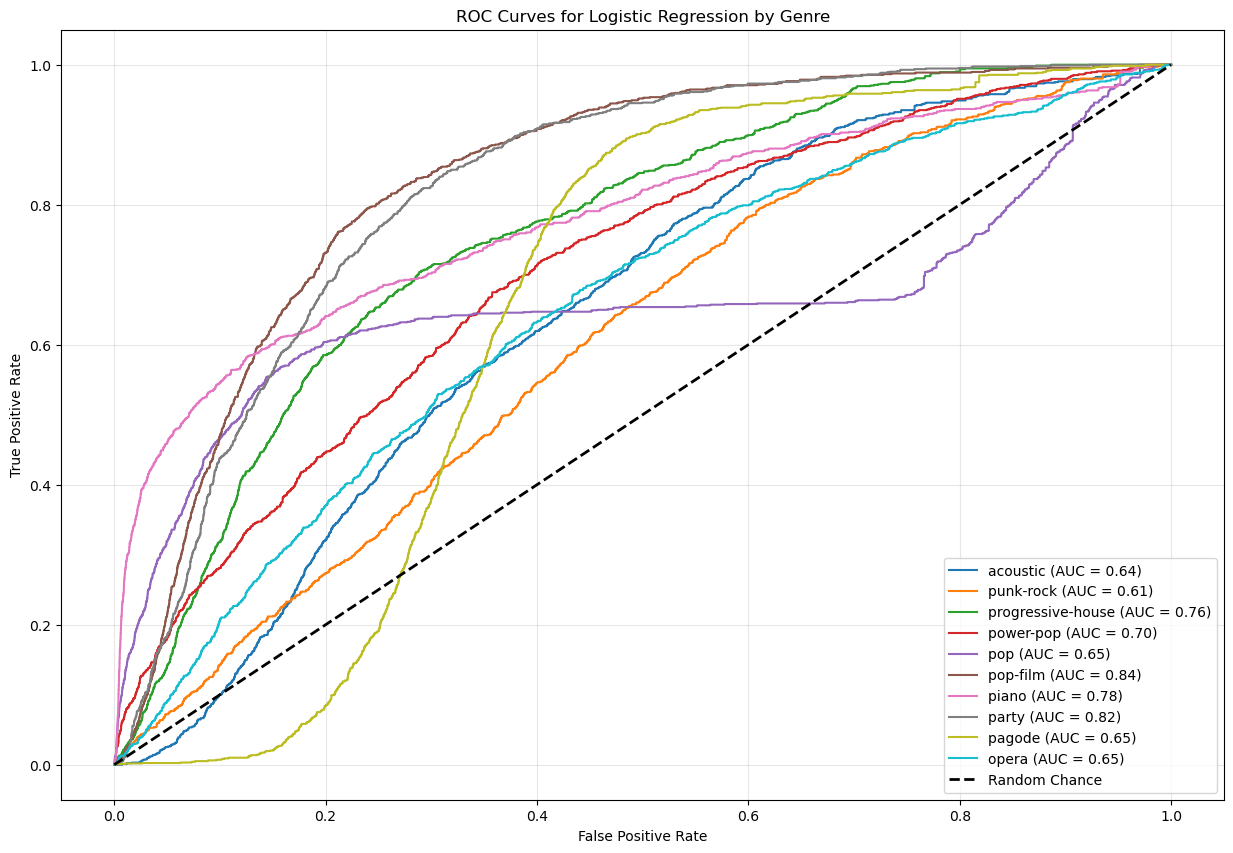

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Function to manually balance classes for a binary target
def balance_classes(X, y):
    # Combine X and y into a single DataFrame for sampling
    data_combined = pd.concat([X, y], axis=1)
    class_0 = data_combined[data_combined[y.name] == 0]
    class_1 = data_combined[data_combined[y.name] == 1]

    # Resample the minority class to match the majority class size
    if len(class_0) > len(class_1):
        class_1_upsampled = resample(class_1, replace=True, n_samples=len(class_0), random_state=42)
        balanced_data = pd.concat([class_0, class_1_upsampled])
    else:
        class_0_upsampled = resample(class_0, replace=True, n_samples=len(class_1), random_state=42)
        balanced_data = pd.concat([class_0_upsampled, class_1])

    # Split back into X and y
    X_balanced = balanced_data[X.columns]
    y_balanced = balanced_data[y.name]
    return X_balanced, y_balanced

def logistic_regression_analysis(data, top_genres, predictors):
    results = []

    for genre in top_genres:
        y = data[f'is_{genre}']
        X = data[predictors]

        # Balance the classes manually
        X_balanced, y_balanced = balance_classes(X, y)

        # Split balanced data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            X_balanced, y_balanced, test_size=0.3, random_state=42
        )

        # Train logistic regression
        model = LogisticRegression(max_iter=1000, random_state=42)
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Generate classification report
        report = classification_report(y_test, y_pred, output_dict=True)
        results.append({
            'Genre': genre,
            'Precision (0)': report['0']['precision'],
            'Recall (0)': report['0']['recall'],
            'F1-Score (0)': report['0']['f1-score'],
            'Precision (1)': report['1']['precision'],
            'Recall (1)': report['1']['recall'],
            'F1-Score (1)': report['1']['f1-score'],
            'Accuracy': report['accuracy'],
            'Macro Precision': report['macro avg']['precision'],
            'Macro Recall': report['macro avg']['recall'],
            'Macro F1-Score': report['macro avg']['f1-score'],
        })

    # Convert to a DataFrame for easier handling
    results_df = pd.DataFrame(results)
    return results_df

def plot_roc_curves(data, top_genres, predictors):
    plt.figure(figsize=(15, 10))

    for genre in top_genres:
        y = data[f'is_{genre}']
        X = data[predictors]

        # Balance the classes manually
        X_balanced, y_balanced = balance_classes(X, y)

        # Split balanced data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            X_balanced, y_balanced, test_size=0.3, random_state=42
        )

        # Train logistic regression
        model = LogisticRegression(max_iter=1000, random_state=42)
        model.fit(X_train, y_train)

        # Predict probabilities for ROC curve
        y_prob = model.predict_proba(X_test)[:, 1]

        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        # Plot each ROC curve
        plt.plot(fpr, tpr, label=f'{genre} (AUC = {roc_auc:.2f})')

    # Plot baseline
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Chance')

    # Customize plot
    plt.title('ROC Curves for Logistic Regression by Genre')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()

# Full pipeline
if __name__ == "__main__":
    # Load data
    data = pd.read_csv('dataset.csv')

    # Define top genres and predictors
    top_genres = ['acoustic', 'punk-rock', 'progressive-house', 'power-pop', 'pop', 'pop-film', 'piano', 'party', 'pagode', 'opera']
    predictors = ['popularity', 'duration_ms', 'danceability', 'energy', 'loudness',
                  'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence',
                  'tempo', 'time_signature']

    # Generate binary columns for top genres
    for genre in top_genres:
        data[f'is_{genre}'] = (data['track_genre'] == genre).astype(int)

    # Perform logistic regression analysis
    results_df = logistic_regression_analysis(data, top_genres, predictors)

    # Display results
    print("Classification Report Summary:")
    print(results_df)

    # Plot ROC curves
    plot_roc_curves(data, top_genres, predictors)
